In [1]:
#import osmnx as ox
import sys

import numpy as np
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import psycopg2
from shapely.geometry import LineString, Polygon, Point
from shapely import wkt
import mplleaflet
from tqdm import tqdm
import geojson
import json

In [3]:
#gdrive = ox.graph_from_place('Los Angeles, CA, USA',network_type='drive')

In [4]:
#gbike = ox.graph_from_place('Los Angeles, CA, USA',network_type='bike')

In [5]:
#import contextily as ctx

#def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
#    xmin, xmax, ymin, ymax = ax.axis()
#    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
#    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
#    ax.axis((xmin, xmax, ymin, ymax))

In [2]:
conn = psycopg2.connect("dbname=la_gis user=karlen")
cur = conn.cursor()

In [3]:
#cur.execute("SELECT highway,maxspeed,lanes,osm_id,bicycle,width FROM planet_osm_roads lplanet_osm_roads WHERE NULLIF(bicycle, '') IS NOT NULL AND bicycle != 'no';")
#cur.execute("SELECT highway,maxspeed,lanes,osm_id,bicycle,width,shoulder FROM planet_osm_line WHERE highway != 'motorway' and highway != 'None' AND highway != 'Trunk' and highway != 'steps';")
cur.execute("SELECT highway,maxspeed,lanes,osm_id,bicycle,width,shoulder FROM planet_osm_line WHERE highway != 'trunk' and highway != 'motorway' and highway != 'trunk_link' and highway != 'motorway_link';")
roads_df = pd.DataFrame(cur.fetchall(),columns=['highway','maxspeed','lanes','id','bicycle','width','shoulder'])

In [4]:
roads_df = roads_df.iloc[np.where(roads_df['bicycle'] != 'no')[0]]
roads_df = roads_df.iloc[np.where(roads_df['highway'] != 'bus_guideway')[0]]
roads_df = roads_df.iloc[np.where(roads_df['highway'] != 'proposed')[0]]
roads_df = roads_df.iloc[np.where(roads_df['highway'] != 'razed')[0]]
roads_df = roads_df.iloc[np.where(roads_df['highway'] != 'abandoned')[0]]
#roads_df[id] = roads_df.id.apply(lambda x: x.astype(int))

In [246]:
hw_keys = pd.unique(roads_df['highway'])
for k in hw_keys:
    lanes = roads_df[roads_df['highway'] == k ].lanes
    tot = len(lanes)
    lanes = lanes[lanes.values != None]
    if len(lanes.values) > 0:
       vals = [int(val.split()[0]) for val in lanes.values]
       print(k,np.size(vals)/float(tot),np.median(vals),[np.min(vals),np.max(vals)])
    else:
        print(k,'empty')

cycleway 0.029069767441860465 2.0 [2, 2]
footway 0.0013228763110649155 1.0 [1, 1]
steps empty
service 0.00718294051627385 2.0 [1, 6]
path 0.0025940337224383916 1.0 [1, 1]
residential 0.14032735601363053 2.0 [0, 6]
pedestrian empty
tertiary 0.6551342374757819 3.0 [1, 8]
secondary 0.7868365180467092 4.0 [1, 9]
unclassified 0.08626198083067092 2.0 [1, 4]
primary 0.9442753699233918 5.0 [1, 10]
secondary_link 0.47804878048780486 1.0 [1, 3]
track 0.0028530670470756064 1.5 [1, 2]
primary_link 0.6226415094339622 1.0 [1, 3]
road empty
tertiary_link 0.175 1.0 [1, 2]
corridor empty
construction 0.23809523809523808 5.0 [4, 5]
living_street empty
platform empty
bus_stop empty
elevator empty
bridleway empty


In [6]:
#getting average speed per type
hw_keys = pd.unique(roads_df['highway'])
for k in hw_keys:
    speeds = roads_df[roads_df['highway'] == k ].maxspeed
    tot = len(speeds)
    speeds = speeds[speeds.values != None]
    if len(speeds.values) > 0:
       vals = [int(val.split()[0]) for val in speeds.values]
       print(k,np.size(vals)/float(tot),np.median(vals),[np.min(vals),np.max(vals)])
    else:
        print(k,'empty')

cycleway empty
footway 0.0001889823301521308 10.0 [10, 10]
steps empty
service 0.004769921436588103 15.0 [5, 25]
path empty
residential 0.04513714317635886 25.0 [5, 56]
pedestrian empty
tertiary 0.16302241904234707 30.0 [20, 48]
secondary 0.1597664543524416 35.0 [15, 56]
unclassified 0.12140575079872204 25.0 [5, 25]
primary 0.15835869451149123 35.0 [25, 80]
secondary_link 0.014634146341463415 30.0 [25, 55]
track 0.0014265335235378032 25.0 [25, 25]
primary_link 0.025157232704402517 35.0 [35, 56]
road empty
tertiary_link empty
bus_guideway empty
corridor empty
construction empty
living_street empty
platform empty
proposed empty
bus_stop empty
razed empty
abandoned empty
elevator empty
bridleway empty


In [5]:
def getnodes(way_id):
    cur.execute("SELECT nodes from planet_osm_ways where id='{}'".format(way_id))
    try:
        return cur.fetchone()[0]
    except TypeError:
        return None

def get_node_coords(node_id):
    cur.execute("SELECT lon,lat from planet_osm_nodes where id='{}'".format(node_id))
    coords = cur.fetchone()
    return (coords[0]/1.E7, coords[1]/1.E7)

def get_way_coords(node_list):
    if node_list:
        coords_list = []
        for node_id in node_list:
            coords_list.append(get_node_coords(node_id))
        return LineString(coords_list)
    else:
        print('fuck')
        return None

roads_df['nodes'] = roads_df['id'].apply(getnodes)
roads_df['geometry'] = roads_df.nodes.apply(get_way_coords)

In [6]:
def find_nearest_seg(point, lines, thresh=1E-4, return_dist=False):
    dist = lines.distance(point)
    id = dist.idxmin()
    if return_dist:
        return id if dist[id] < thresh else np.nan,dist
    else:
        return id if dist[id] < thresh else np.nan

SL = {'elevator':5,'bus_stop': 15,'platform':15, 'corridor': 5,'cycleway': 15, 'footway' : 5, 'steps' : 0, 'service' : 30, 
      'path' : 15, 'residential':25,'living_street':25,'bridleway': 10,
       'pedestrian' : 5, 'tertiary': 30, 'secondary' : 30, 'unclassified' : 20,
       'trunk_link' : 55, 'motorway_link' : 55, 'primary': 35, 'secondary_link': 30, 'road':30,
       'primary_link' : 35, 'tertiary_link' : 30, 'track' : 0, 'construction': 30}

NL = {'elevator':1,'bus_stop':2,'platform':1,'corridor':1,'cycleway': 2, 'footway' : 1, 'steps' : 1, 'service' : 2, 
      'path' : 2, 'residential': 2, 'living_street': 2, 'bridleway':1,
       'pedestrian' : 1, 'tertiary': 3, 'secondary' : 4, 'unclassified' : 2,
       'trunk_link' : 2, 'motorway_link' : 2, 'primary': 5, 'secondary_link': 2, 'road':2,
       'primary_link' : 2, 'tertiary_link' : 2, 'track' : 1, 'construction': 2}

def populate_speeds(highway,maxspeed):
    speeds = []
    for hw,speed in zip(highway,maxspeed):
        if speed:
            speeds.append(int(speed.split()[0]))
        else:
            speeds.append(SL[hw])
    return speeds


def populate_lanes(highway,lanes):
    l = []
    for hw,lane in zip(highway,lanes):
        if lane:
            l.append(lane)
        else:
            l.append(NL[hw])
    return l

speeds = populate_speeds(roads_df['highway'],roads_df['maxspeed'])
lanes = populate_lanes(roads_df['highway'],roads_df['lanes'])
roads_df['speed_lim'] = speeds
roads_df['nlanes'] = lanes
#roads_df

In [7]:
crs = {'init': 'epsg:4326'}
roads_geodf = gp.GeoDataFrame(roads_df, geometry='geometry',crs=crs)

In [14]:
fig, ax = plt.subplots(1)
roads_geodf.plot(ax = ax)
mplleaflet.show(fig=fig)

In [111]:
SW = [33.930416, -118.539958]
NE = [34.158886, -118.201925]
meshy = np.linspace(SW[0],NE[0],3)
meshx = np.linspace(SW[1],NE[1],3)

poly_bl = [(meshx[0],meshy[0]),(meshx[0],meshy[1]),(meshx[1],meshy[1]),(meshx[1],meshy[0]),(meshx[0],meshy[0])] #bot left
poly_tl = [(meshx[0],meshy[1]),(meshx[0],meshy[2]),(meshx[1],meshy[2]),(meshx[1],meshy[1]),(meshx[0],meshy[1])] #top left
poly_tr = [(meshx[1],meshy[1]),(meshx[1],meshy[2]),(meshx[2],meshy[2]),(meshx[2],meshy[1]),(meshx[1],meshy[1])] #top right
poly_br = [(meshx[1],meshy[0]),(meshx[1],meshy[1]),(meshx[2],meshy[1]),(meshx[2],meshy[0]),(meshx[1],meshy[0])] #bot right
polys = [poly_bl,poly_tl,poly_tr,poly_br]

In [ ]:
poly_bl

In [176]:
#nodez = [535595810, 5762680507]
#
#roads_df2 = roads_df.iloc[np.where(roads_df['lanes'].values != None)[0]]
#roads_df2['nodes'] = roads_df2['id'].apply(getnodes)
#roads_df2['geometry'] = roads_df2.nodes.apply(get_way_coords)

/Users/karlen/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/karlen/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [177]:
#roads_geodf2 = gp.GeoDataFrame(roads_df2, geometry='geometry')
#fig, ax = plt.subplots(1)
#roads_geodf2.plot(ax = ax)
#mplleaflet.show(fig=fig)

In [9]:
base = '/Users/karlen/Work/Insight/data/raw/'
fpavcond = base+'pavement/pa12-15.csv'
#fpavcond = base+'pavement_cond.csv'
df_pavcond = pd.read_csv(fpavcond)
df_pavcond.the_geom = df_pavcond.the_geom.apply(wkt.loads)
pav_geo_df = gp.GeoDataFrame(df_pavcond, geometry='the_geom')

In [10]:
roads_geodf_exp = roads_geodf.copy()
roads_geodf_exp = roads_geodf_exp.drop(roads_geodf_exp.index)

for rank,row in tqdm(roads_geodf.iterrows()):

    lines = wkt.dumps(row.geometry)[12:-1].split(',')
    
    N = len(lines)
    
    if N > 2:
    
        start = lines[0]
        for i in range(N-1):
            end = lines[i+1]
            lstring = wkt.loads("Linestring({l1},{l2})".format(l1=start,l2=end))
            start = end
            tmp_row = row.copy()
            tmp_row['geometry'] = lstring
            roads_geodf_exp = roads_geodf_exp.append(tmp_row)
    else:
        roads_geodf_exp = roads_geodf_exp.append(row)

72445it [38:52:32, 12.21s/it]


In [244]:
#roads_geodf_exp = roads_geodf_exp.drop(['nodes','id','lanes','maxspeed'],axis=1)#.to_csv('roads_exp_trim.csv',index=False)

In [24]:
roads_geodf_exp = roads_geodf_exp.reset_index()

In [98]:
roads_geodf_exp.geometry.loc[200000].within(Polygon(poly_tl))

False

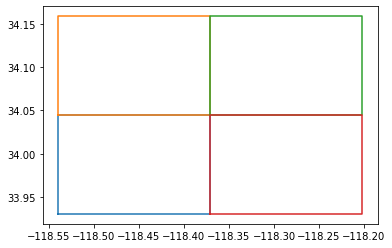

In [112]:
for poly in polys:
    xs = [point[0] for point in poly]
    ys = [point[1] for point in poly]
    plt.plot(xs,ys)

In [181]:
#coords = [(-118.38, 34.0), (-118.38, 34.1), (-118.22, 34.1), (-118.22, 34.0)]
#coords = [(-118.5244,33.9559),(-118.5244,34.0779),(-118.3679,34.0779),(-118.3679,33.9559)]
poly_grid = [Polygon(poly) for poly in polys]


def crop_pav(xy,poly):
    x = xy[0][0]
    y = xy[1][0]
    p = Point(x,y)
    return p.within(poly)

def crop_roads(l,p):
    return l.within(p)

def crop_col(x,y,poly):
    p = Point(x,y)
    return p.within(poly)

In [133]:
#cropping pav_df - this is really inefficient, but whateva

geom = pav_geo_df.the_geom

keep_cols = []

for poly in poly_grid:
    
    keep = []
    

    for row in tqdm(geom):
        xy = row.geoms[0].coords.xy
        keep.append(crop_pav(xy,poly))
    
    keep_cols.append(keep)

    
    
pav_geo_df['keep'] = keep_cols[0]
pav_geodf_bl = pav_geo_df[pav_geo_df.keep]

pav_geo_df['keep'] = keep_cols[1]
pav_geodf_tl = pav_geo_df[pav_geo_df.keep]

pav_geo_df['keep'] = keep_cols[2]
pav_geodf_tr = pav_geo_df[pav_geo_df.keep]

pav_geo_df['keep'] = keep_cols[3]
pav_geodf_br = pav_geo_df[pav_geo_df.keep]

100%|██████████| 72562/72562 [00:16<00:00, 4380.93it/s]


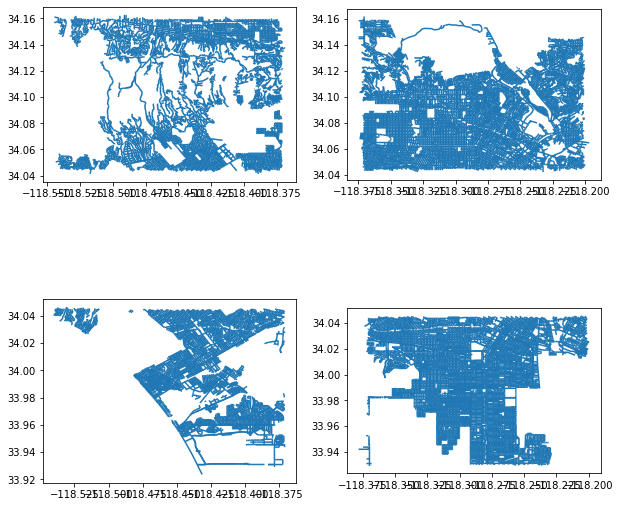

In [135]:
fig_pav, ((ax1_pav,ax2_pav),(ax3_pav,ax4_pav)) = plt.subplots(2,2,figsize=(10,10))
pav_geodf_tl.plot(ax=ax1_pav)
pav_geodf_tr.plot(ax=ax2_pav)
pav_geodf_bl.plot(ax=ax3_pav)
pav_geodf_br.plot(ax=ax4_pav)

In [142]:
pav_geo_list = [pav_geo.drop(['ST_NAME','keep','STATUS'],axis=1) for pav_geo in [pav_geodf_bl,pav_geodf_tl,pav_geodf_tr,pav_geodf_br]]

In [114]:
geometry = roads_geodf_exp.geometry

keep_cols_roads = []

for poly in poly_grid:
    
    keep = []
    
    for line in tqdm(geometry):
        keep.append(crop_roads(line,poly))
    
    keep_cols_roads.append(keep)

100%|██████████| 365847/365847 [00:06<00:00, 58895.87it/s]


In [115]:
seg_roads_list = [roads_geodf_exp[keep].drop('index',axis=1) for keep in keep_cols_roads]

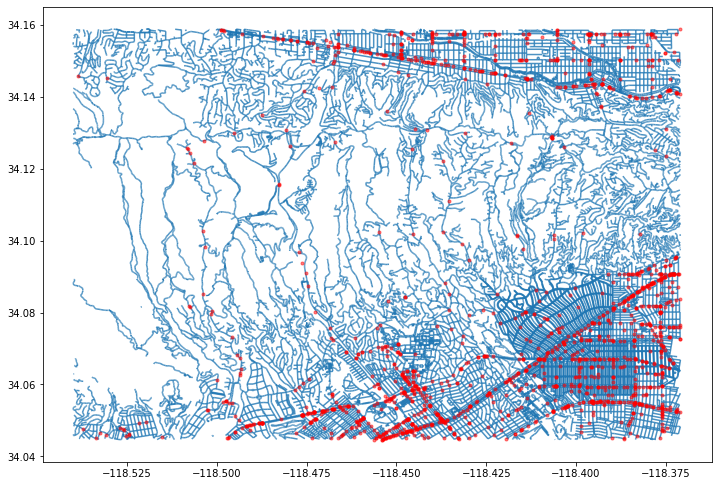

In [234]:
#drawing LA for verification fun
fig, ax1= plt.subplots(1,figsize=(12,12))
seg_roads_list[1].plot(ax=ax1,zorder=50,alpha=0.8)
acc_gdf_list[1].plot(color='red',ax=ax1,marker='.',alpha=0.5,zorder=100)

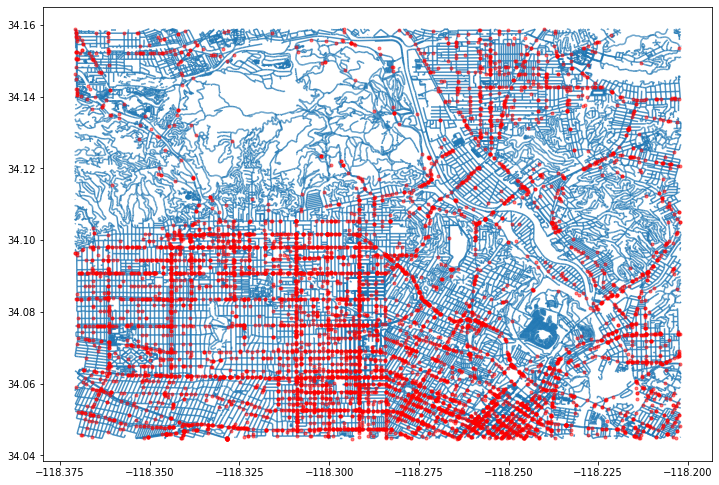

In [233]:
fig, ax2= plt.subplots(1,figsize=(12,12))
seg_roads_list[2].plot(ax=ax2,zorder=50,alpha=0.8)
acc_gdf_list[2].plot(color='red',ax=ax2,marker='.',alpha=0.5,zorder=100)


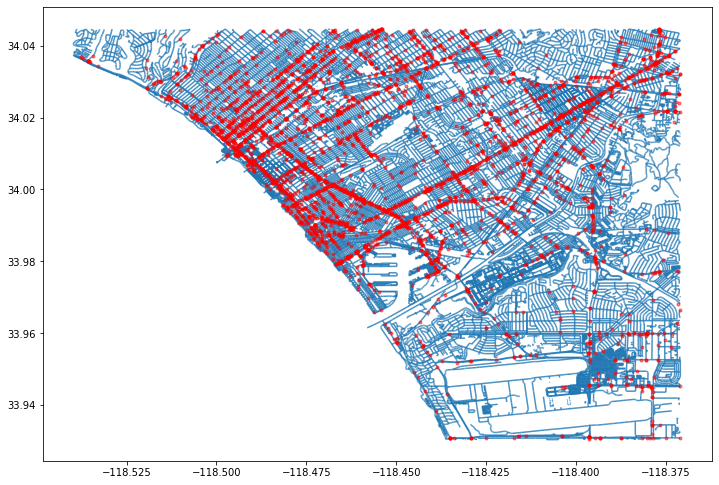

In [235]:
fig, ax3= plt.subplots(1,figsize=(12,12))
seg_roads_list[0].plot(ax=ax3,zorder=50,alpha=0.8)
acc_gdf_list[0].plot(color='red',ax=ax3,marker='.',alpha=0.5,zorder=100)


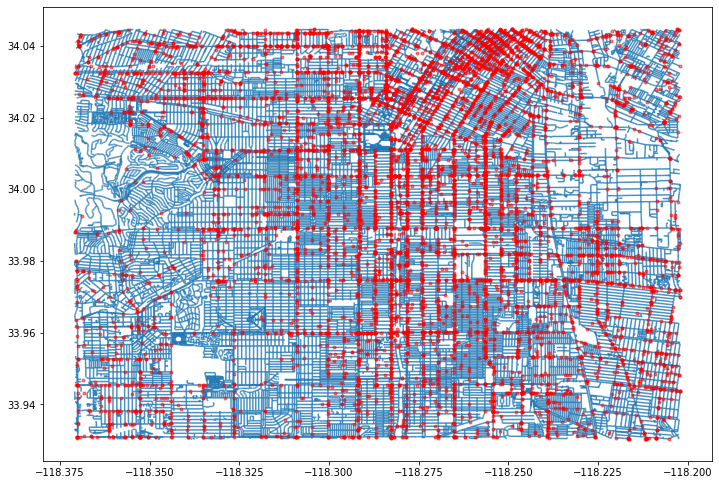

In [236]:
fig, ax4= plt.subplots(1,figsize=(12,12))
seg_roads_list[3].plot(ax=ax4,zorder=50,alpha=0.8)
acc_gdf_list[3].plot(color='red',ax=ax4,marker='.',alpha=0.5,zorder=100)

In [147]:
#real ugly but prettiness boat has sailed and don't want these interrupted
roads_seg_list = []
#for roadz,pavz in tqdm(zip(seg_roads_list,pav_geo_list)):

road_seg0 = []
for line in seg_roads_list[0].geometry:
    road_seg0.append(find_nearest_seg(line,pav_geo_list[0],1E-4))
roads_seg_list.append(road_seg0)

In [149]:
road_seg1 = []
for line in seg_roads_list[1].geometry:
    road_seg1.append(find_nearest_seg(line,pav_geo_list[1],1E-4))
roads_seg_list.append(road_seg1)

In [150]:
road_seg2 = []
for line in seg_roads_list[2].geometry:
    road_seg2.append(find_nearest_seg(line,pav_geo_list[2],1E-4))
roads_seg_list.append(road_seg2)

In [151]:
road_seg3 = []
for line in seg_roads_list[3].geometry:
    road_seg3.append(find_nearest_seg(line,pav_geo_list[3],1E-4))
roads_seg_list.append(road_seg3)

In [159]:
for road_seg,pave_seg in zip(seg_roads_list,roads_seg_list):
    road_seg['pave_ref'] = pave_seg

In [168]:
seg_roads_list[3].to_csv('roads_exp3_wpav.csv',index=False)
#saved these; only references, haven't populated PCI yet

In [192]:
col1 = base + 'collisions/Collisions_2006_2012.csv'
col2 = base + 'collisions/Collisions_2003_2018.csv'
df_col1 = pd.read_csv(col1)
df_col2 = pd.read_csv(col2)

In [209]:
df_col = pd.concat([df_col1, df_col2])

In [210]:
df_col['GEOMETRY'] = gp.points_from_xy(df_col.POINT_X, df_col.POINT_Y)

In [211]:
cols = df_col[['POINT_X','POINT_Y','GEOMETRY']]

cols = cols.dropna()

In [212]:
keep_cols_acc = []
for poly in poly_grid:
    
    keep = []
    

    for x,y in zip(cols['POINT_X'],cols['POINT_Y']):
        keep.append(crop_col(x,y,poly))
    
    keep_cols_acc.append(keep)

In [213]:
acc_geo_list = [cols[keep] for keep in keep_cols_acc]

In [216]:
crs = {'init': 'epsg:4326'}
acc_gdf_list = [gp.GeoDataFrame(df_col, crs=crs, geometry='GEOMETRY') for df_col in acc_geo_list]

In [240]:
acc_seg_list = []

acc_seg = []
for point in acc_gdf_list[0].geometry:
    acc_seg.append(find_nearest_seg(point,seg_roads_list[0],1.E-4))
acc_seg_list.append(acc_seg)

In [241]:
acc_seg = []
for point in acc_gdf_list[1].geometry:
    acc_seg.append(find_nearest_seg(point,seg_roads_list[1],1.E-4))
acc_seg_list.append(acc_seg)

In [242]:
acc_seg = []

for point in acc_gdf_list[2].geometry:
    acc_seg.append(find_nearest_seg(point,seg_roads_list[2],1.E-4))
acc_seg_list.append(acc_seg)

In [243]:
acc_seg = []

for point in acc_gdf_list[3].geometry:
    acc_seg.append(find_nearest_seg(point,seg_roads_list[3],1.E-4))
acc_seg_list.append(acc_seg)

In [265]:
for acc_gdf,acc_seg,roads_gdf in zip(acc_gdf_list,acc_seg_list,seg_roads_list):
    acc_gdf['accseg']=acc_seg
    acc_counts = acc_gdf.groupby('accseg')['GEOMETRY'].count()
    roads_gdf['nacc'] = 0
    for c,ind in enumerate(acc_counts.index):
        roads_gdf.at[int(ind),'nacc'] += int(acc_counts.iloc[c])

In [272]:
seg_roads_wpav_list = [roads_gdf.dropna(subset=['pave_ref']) for roads_gdf in seg_roads_list]
for roads_gdf_wpav,pav_gdf in zip(seg_roads_wpav_list,pav_geo_list):
    roads_gdf_wpav['PCI'] = roads_gdf_wpav.pave_ref.apply(lambda x: pav_gdf.loc[x].PCI)

/Users/karlen/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [287]:
seg_roads_list[3].to_csv('roads_exp3.csv',index=False)

In [ ]:
keep_col = []
for x,y in zip(df_col['POINT_X'],df_col['POINT_Y']):
    keep_col.append(crop_col(x,y))

In [783]:
roads_geodf2['pave_ref'] = road_seg

In [224]:
#print(roads_geodf.loc[19573].geometry)
roads_geodf_alt = roads_geodf.copy()

In [228]:
roads_geodf_alt['pgeo'] = roads_geodf_alt.pave_ref.apply(lambda x: geo_df.loc[x].the_geom)

In [231]:
roads_geodf_alt['geometry'] = roads_geodf_alt['pgeo']

In [839]:
roads_geodf_wpav = roads_geodf2.dropna(subset=['pave_ref'])
roads_geodf_wpav['PCI'] = roads_geodf_wpav.pave_ref.apply(lambda x: geo_df.loc[x].PCI)


/Users/karlen/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [169]:
#fig,ax = plt.subplots(1,figsize=(12,12))
#roads_geodf.plot(ax=ax,edgecolor='k')
#roads_geodf_alt.plot(ax=ax,edgecolor='b')
fcolli_tims = base + 'collisions/tims_collisions.csv'
df_col = pd.read_csv(fcolli_tims)

In [513]:
coords = [(-118.5244,33.9559),(-118.5244,34.0779),(-118.3679,34.0779),(-118.3679,33.9559)]
poly = Polygon(coords)

def crop_col(x,y):
    p = Point(x,y)
    return p.within(poly)

inds = np.where(df_col['POINT_X'])

nbins = 50

xs = np.array(df_col['POINT_X'])[inds]
ys = np.array(df_col['POINT_Y'])[inds]

df_col = df_col.loc[inds]

ind2 = ~np.isnan(xs)
xs = xs[ind2]
ys = ys[ind2]
df_col = df_col.loc[ind2]

keep_col = []
for x,y in zip(df_col['POINT_X'],df_col['POINT_Y']):
    keep_col.append(crop_col(x,y))

df_col['keep'] = keep_col
df_col = df_col[df_col.keep]
    
xs = np.array(df_col['POINT_X'])
ys = np.array(df_col['POINT_Y'])

/Users/karlen/anaconda3/envs/insight/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [514]:
df_col['GEOMETRY'] = gp.points_from_xy(df_col.POINT_X, df_col.POINT_Y)
geo_col_df = gp.GeoDataFrame(df_col, crs=crs, geometry='GEOMETRY')

In [518]:
acc_seg = []
cdlim = 0.01
for point in geo_col_df.geometry:
    acc_seg.append(find_nearest_seg(point,roads_geodf2,0.1))

In [519]:
geo_col_df['accseg']=acc_seg
acc_counts = geo_col_df.groupby('accseg')['GEOMETRY'].count()

roads_geodf2['nacc'] = 0

#seg = acc_seg[0]

#geo_col_df
#geo_df.loc[57354]
for c,ind in enumerate(acc_counts.index):
    roads_geodf2.at[ind,'nacc'] += int(acc_counts.iloc[c])

In [247]:
speeds = populate_speeds(roads_geodf['highway'],roads_geodf['maxspeed'])
roads_geodf['speed_lim'] = speeds

In [766]:
#no pavement
acc_df = roads_geodf2[roads_geodf2.nacc > 0]
acc_df = acc_df.loc[acc_df.index.repeat(acc_df['nacc'])]
acc_df.loc[:]['nacc'] = 1
noacc_df = roads_geodf2[roads_geodf2.nacc == 0]

In [845]:
#with pavement
acc_df = roads_geodf_wpav[roads_geodf_wpav.nacc > 0]
acc_df = acc_df.loc[acc_df.index.repeat(acc_df['nacc'])]
acc_df.loc[:]['nacc'] = 1
noacc_df = roads_geodf_wpav[roads_geodf_wpav.nacc == 0]

In [847]:
sampled_noacc_df = noacc_df.sample(300)
comb_df = pd.concat([acc_df,sampled_noacc_df])
comb_wlanes = comb_df[comb_df.lanes.values != None]

In [712]:
#print(acc_df.highway.groupby(acc_df.highway).count())
#roads_geodf.highway.groupby(noacc_df.highway).count()
print(acc_df.lanes.groupby(acc_df.lanes).count()/roads_geodf.lanes.groupby(noacc_df.lanes).count())

lanes
1     0.015385
10         NaN
2     0.095153
3     0.093023
4     0.142442
5     0.093548
6     0.097222
7     0.131034
8     0.117647
9          NaN
Name: lanes, dtype: float64


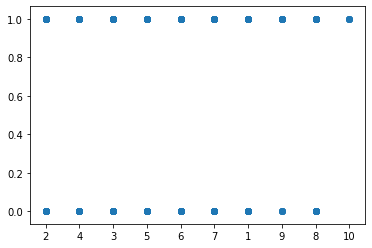

In [345]:
plt.scatter(comb_wlanes.lanes,comb_wlanes.nacc)

In [849]:
import sklearn.model_selection
from sklearn import linear_model, model_selection
X = comb_wlanes[['nlanes','speed_lim','PCI']]
#X = comb_wlanes[['speed_lim']]
y = comb_wlanes[['nacc']]

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X,y, test_size=0.2)

In [769]:
#lrm = linear_model.LinearRegression()
#lrm.fit(X_train,y_train)

In [770]:
#for index, row in roads_geodf.iterrows():
#    print(row.values)

In [850]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train.nacc.values)

#clf = LogisticRegressionCV(cv=5, max_iter=300, solver='liblinear')#, class_weight='balanced')
clf.fit(X_train, y_train)


/Users/karlen/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [851]:
clf.score(X_valid,y_valid)

0.5483870967741935

(array([ 454.,  374.,  315., 3178., 2196., 1470.,  906.,  534.,  170.,
          21.]),
 array([0.34074587, 0.39117097, 0.44159607, 0.49202118, 0.54244628,
        0.59287138, 0.64329648, 0.69372158, 0.74414669, 0.79457179,
        0.84499689]),
 <a list of 10 Patch objects>)

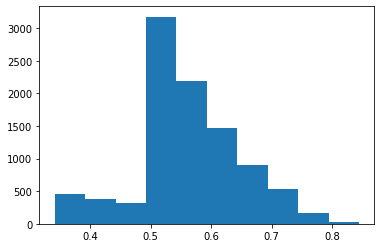

In [854]:
probs = clf.predict_proba(roads_geodf_wpav[['nlanes','speed_lim','PCI']])

acc_prob = [p[1] for p in probs]
plt.hist(acc_prob)

Text(0.5, 1.0, 'Logistic regression coefficients')

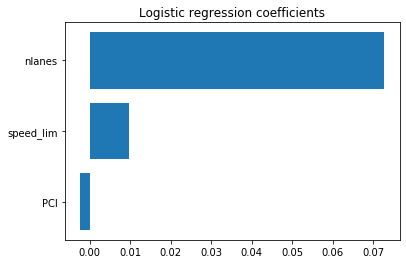

In [855]:
plt.barh(range(len(clf.coef_[0])),
         width=np.sort(clf.coef_[0]))
plt.yticks(ticks=range(len(clf.coef_[0])), labels=X.columns[np.argsort(clf.coef_[0])])
plt.title('Logistic regression coefficients')

In [666]:
def data2geojson(df,filename='acc_layer.geojson'):
    features = []
    
    insert_features = lambda X: features.append(            
            geojson.Feature(geometry=X['geometry'],
                            properties={'id': X['id'], 'acc_prob': X['acc_prob']}))
    
    df.apply(insert_features, axis=1)
    with open(filename, 'w', encoding='utf8') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)

In [500]:
#I can just use the cls.proba(X) for my probabilities...

#roads_geodf.to_crs({'init': 'epsg:4326'})

#copied over from cycle-safe

roads_geodf2['acc_prob'] = acc_prob
layer = roads_geodf2[['id','acc_prob','geometry']]

data2geojson(layer)

In [497]:
#roads_geodf['nodes'] = roads_geodf['nodes'].apply(json.dumps)
roads_geodf.to_file('roads_geodf_back.shp')

In [505]:
#roads_geodf2 = df.read_csv('roads_geodf_back.csv')
roads_geodf2 = gp.read_file('roads_geodf_back.shp')

#roads_geodf2.columns[13] = 'geometry2'

#roads_geodf2 = roads_geodf2.drop(roads_geodf2.columns[13],axis=1)
##roads_geodf2 = gp.GeoDataFrame(roads_geodf2, geometry='geometry')

In [775]:
roads_geodf2['acc_prob'] = acc_prob

In [402]:
def isNaN(num):
    return num != num


def populate_lanes(highway,lanes):
    l = []
    for hw,lane in zip(highway,lanes):
        if lane and not isNaN(lane):
            l.append(lane)
        else:
            l.append(NL[hw])
    return l

lanes = populate_lanes(roads_geodf2['highway'],roads_geodf2['lanes'])
roads_geodf2['nlanes'] = lanes

In [646]:
desi = roads_geodf2[roads_geodf2.bicycle == 'designated'].groupby(by='nacc').count().id
cts = roads_geodf2[roads_geodf2.bicycle.apply(lambda x: x is None)].groupby('nacc').count().id
roads_geodf2

,highway,maxspeed,lanes,id,bicycle,width,shoulder,speed_lim,nodes,pave_ref,nlanes,geometry,nacc,acc_prob
0,cycleway,None,2,4341259,None,None,None,15,"[400857855, 400864303, 400864308, 1363778082, ...",31011,2,"LINESTRING (-118.4824233 33.9965151, -118.4822...",0,0.248690
1,footway,None,None,94446292,None,None,None,5,"[243740311, 1097085164, 1097085252, 1097085189...",19808,1,"LINESTRING (-118.4773777 33.9905691, -118.4771...",0,0.271175
2,footway,None,None,160347811,None,None,None,5,"[122714157, 1723968933]",19808,1,"LINESTRING (-118.4768789 33.9905978, -118.4770...",0,0.271175
3,steps,None,None,285608119,None,None,None,0,"[2892740983, 2892740984]",28083,1,"LINESTRING (-118.499798 34.0074088, -118.49962...",0,0.290767
4,steps,None,None,285608115,None,None,None,0,"[2892740985, 2892740987]",28083,1,"LINESTRING (-118.4999171 34.0075224, -118.4998...",0,0.290767
5,footway,None,None,558431970,None,None,None,5,"[5994040777, 2892740983, 5599997671, 289274098...",28083,1,"LINESTRING (-118.4997637 34.0073498, -118.4997...",0,0.271175
6,footway,None,None,448031304,None,None,None,5,"[4450863930, 6034830164, 6034830163, 603483016...",28083,1,"LINESTRING (-118.4882588 34.0019518, -118.4878...",0,0.271175
7,service,None,None,408470233,None,None,None,30,"[6204947827, 4103924670, 4103924674, 4103924681]",28083,2,"LINESTRING (-118.4882738 34.0026192, -118.4879...",0,0.198352
8,service,None,None,408470235,None,None,None,30,"[6204947827, 4103924681]",28083,2,"LINESTRING (-118.4882738 34.0026192, -118.4881...",0,0.198352
9,service,None,None,640616994,None,None,None,30,"[4103924678, 6204947829, 6204947828, 410392467...",28083,2,"LINESTRING (-118.4876798 34.0024142, -118.4876...",0,0.198352


In [776]:
roads_geodf_test = roads_geodf2.copy()

def applyrule(df,rule,penalty):
    df.loc[rule,['acc_prob']] = df.loc[rule].acc_prob + penalty

def sendrules(df):
    applyrule(df, df.speed_lim > 35, 0.2)
    applyrule(df, df.speed_lim > 30, 0.15)
    applyrule(df, df.speed_lim > 25, 0.1)
    applyrule(df, df.nacc > 0, 0.2)
    applyrule(df, df.nacc > 1, 0.2)
    applyrule(df, df.bicycle == 'designated', -0.5)
    applyrule(df, (df.bicycle == 'yes') | (df.bicycle == 'permissive'), - 0.3)

In [777]:
sendrules(roads_geodf_test)
roads_geodf_test.loc[roads_geodf_test.acc_prob < 0,['acc_prob']] = 0

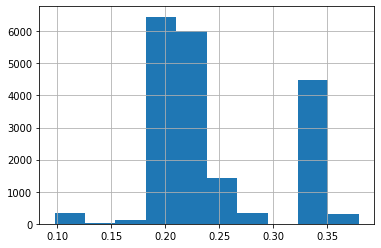

In [778]:
roads_geodf2.acc_prob.hist()

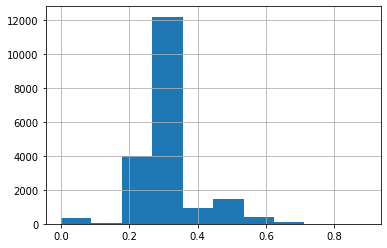

In [779]:
roads_geodf_test.acc_prob.hist()

In [781]:
layer = roads_geodf_test[['id','acc_prob','geometry']]

data2geojson(layer,filename='acc_layer2.geojson')

In [793]:
roads_geodf_test.groupby('nacc').count()

,highway,maxspeed,lanes,id,bicycle,width,shoulder,speed_lim,nodes,pave_ref,nlanes,geometry,acc_prob
nacc,,,,,,,,,,,,,
0,19216,1612,5320,19216,428,6,0,19216,19216,19216,19216,19216,19216
1,236,21,150,236,14,0,0,236,236,236,236,236,236
2,25,5,15,25,3,0,0,25,25,25,25,25,25
3,4,0,3,4,0,0,0,4,4,4,4,4,4
4,1,0,0,1,0,0,0,1,1,1,1,1,1
5,1,1,1,1,0,0,0,1,1,1,1,1,1
